# 1 Import libraries

In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import random
import itertools

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow .keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, cohen_kappa_score, balanced_accuracy_score, accuracy_score, confusion_matrix

# 2 Read Data

## A- convert files to lists

In [22]:
Path_data = '/kaggle/input/diabetic-retinopathy-dataset'
data = os.listdir(Path_data)
Healthy = os.listdir('/kaggle/input/diabetic-retinopathy-dataset/Healthy')
Mild = os.listdir('/kaggle/input/diabetic-retinopathy-dataset/Mild DR')
Moderate = os.listdir('/kaggle/input/diabetic-retinopathy-dataset/Moderate DR')
Proliferate = os.listdir('/kaggle/input/diabetic-retinopathy-dataset/Proliferate DR')
Severe = os.listdir('/kaggle/input/diabetic-retinopathy-dataset/Severe DR')

In [23]:
print("classes names :", (data), "\n______________________________\n")
print("Number of classes :", len(data), "\n______________________________\n")
print("Number of Healty images :", len(Healthy), "\n______________________________\n")
print("Number of Mild images :", len(Mild),  "\n______________________________\n")
print("Number of Moderate images :", len(Moderate),  "\n______________________________\n")
print("Number of Proliferate images :", len(Proliferate),  "\n______________________________\n")
print("Number of severe images :", len(Severe),  "\n______________________________\n")

classes names : ['Severe DR', 'Healthy', 'Moderate DR', 'Mild DR', 'Proliferate DR'] 
______________________________

Number of classes : 5 
______________________________

Number of Healty images : 1000 
______________________________

Number of Mild images : 370 
______________________________

Number of Moderate images : 900 
______________________________

Number of Proliferate images : 290 
______________________________

Number of severe images : 190 
______________________________



## B- Create a dataframe

In [24]:
# Get Paths

Path_data = '/kaggle/input/diabetic-retinopathy-dataset'

# Create two lists to store paths of images and their labels

imgpaths = []
labels =[]


# Convert directory to list

data = os.listdir(Path_data)

# Get paths and Labels of classes and images in data 

for i in data:
    classpath = os.path.join(Path_data, i)
    imglist = os.listdir(classpath)
    
    for img in imglist:
        imgpath = os.path.join(classpath, img)
        
        imgpaths.append(imgpath)
        labels.append(i)


# Convert two lists of imgpaths and their labels into series

Paths = pd.Series(imgpaths, name = 'Paths')
Labels = pd.Series(labels, name = 'Labels')

# Concatenate them in one Dataframe called Tr_data

Df= pd.concat([Paths, Labels], axis = 1)
Df.head(5)

,Paths,Labels
0,/kaggle/input/diabetic-retinopathy-dataset/Sev...,Severe DR
1,/kaggle/input/diabetic-retinopathy-dataset/Sev...,Severe DR
2,/kaggle/input/diabetic-retinopathy-dataset/Sev...,Severe DR
3,/kaggle/input/diabetic-retinopathy-dataset/Sev...,Severe DR
4,/kaggle/input/diabetic-retinopathy-dataset/Sev...,Severe DR


# 3 Data Preprocessing

## A- Split data into train, valid, test

In [25]:
#train, valid  and test dataframes
train, testval = train_test_split(Df, test_size = 0.2, shuffle = True, random_state = 123)
valid, test = train_test_split(testval, test_size = 0.5, shuffle = True, random_state = 123)

print("Train shape: ", train.shape)
print("Valid shape: ", valid.shape)
print("Test shape: ",test.shape)

train.Labels.value_counts()

Train shape:  (2200, 2)
Valid shape:  (275, 2)
Test shape:  (275, 2)


Labels
Healthy           796
Moderate DR       724
Mild DR           290
Proliferate DR    236
Severe DR         154
Name: count, dtype: int64

## B- Data Augmentation

In [26]:
batch_size = 20   # As smaller, As more data generated ....In views of data size 
img_size = (224, 224) # standard value (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)


#Create generators

tr_G = ImageDataGenerator(
    zca_whitening=True,
    rotation_range=30.,
    fill_mode='nearest',
    )

V_G = ImageDataGenerator()

t_G = ImageDataGenerator()

#Generate Appropriate Data for fitting into model

Train = tr_G.flow_from_dataframe(train, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Valid = V_G.flow_from_dataframe(valid, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Test = t_G.flow_from_dataframe(test, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = False, batch_size = batch_size)

/opt/conda/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1444: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn(


Found 2200 validated image filenames belonging to 5 classes.
Found 275 validated image filenames belonging to 5 classes.
Found 275 validated image filenames belonging to 5 classes.


# 4 Modelling

In [27]:
base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = True

# Create your own fully connected layers on top of the model base
x = Flatten()(base_model.output)
x = Dense(64, activation='relu')(x) # Number of Nodes
output = Dense(5, activation='softmax')(x)

# Create a new model by combining the base model and custom layers
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])


## A - Training phase

In [28]:
epochs = 20
history = model.fit(x= Train, epochs= epochs, verbose= 1, validation_data= Valid, validation_steps= None, shuffle= False)

/opt/conda/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1884: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/20


2023-12-11 12:52:33.372521: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


110/110 [==============================] - 115s 346ms/step - loss: 1.3872 - acc: 0.5673 - val_loss: 0.8396 - val_acc: 0.6909
Epoch 2/20
110/110 [==============================] - 35s 320ms/step - loss: 0.9405 - acc: 0.6573 - val_loss: 0.7955 - val_acc: 0.6873
Epoch 3/20
110/110 [==============================] - 36s 321ms/step - loss: 0.8749 - acc: 0.6645 - val_loss: 0.7634 - val_acc: 0.6836
Epoch 4/20
110/110 [==============================] - 35s 318ms/step - loss: 0.8396 - acc: 0.6818 - val_loss: 0.7847 - val_acc: 0.6764
Epoch 5/20
110/110 [==============================] - 35s 318ms/step - loss: 0.8316 - acc: 0.6827 - val_loss: 1.4461 - val_acc: 0.6655
Epoch 6/20
110/110 [==============================] - 35s 319ms/step - loss: 0.7821 - acc: 0.6945 - val_loss: 1.8736 - val_acc: 0.6073
Epoch 7/20
110/110 [==============================] - 35s 318ms/step - loss: 0.8399 - acc: 0.6832 - val_loss: 88.5688 - val_acc: 0.6473
Epoch 8/20
110/110 [==============================] - 35s 318ms/

## B - Evaluation 

In [29]:
# accuracy and loss of Train

tr_acc = history.history['acc']
tr_loss = history.history['loss']


# accuracy and loss or Valid\

v_acc = history.history['val_acc']
v_loss = history.history['val_loss']


# highest value of v_acc by getting its index

index_acc = np.argmax(v_acc)
high_Vacc = v_acc[index_acc]


# lowest value of v_loss by getting index

index_loss = np.argmin(v_loss)
low_Vloss = v_loss[index_loss]


# n. of epochs based on length of tr_acc values

Epochs =[]
for i in range(len(tr_acc)):
    Epochs.append (i+1)

    
# Define best epoch

best_acc = f'Best epoch ={str(index_acc +1)}'
best_loss = f'Best epoch ={str(index_loss+1)}'

## C- Let's Visualize it

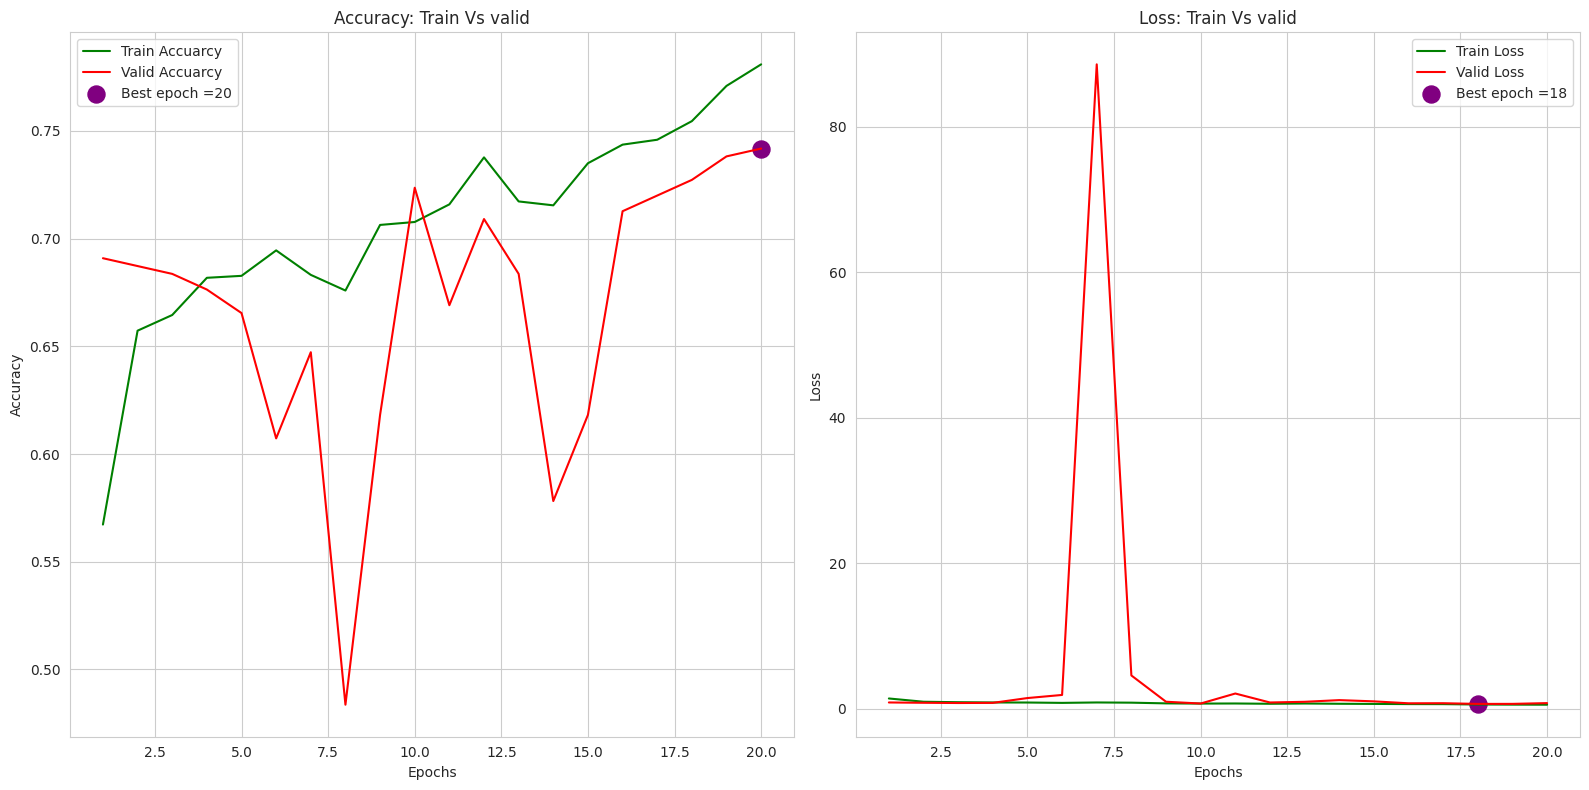

In [30]:
plt.figure(figsize = (16, 8))


plt.subplot(1,2,1)
plt.plot(Epochs, tr_acc, "g", label = "Train Accuarcy")
plt.plot(Epochs, v_acc, "r", label = "Valid Accuarcy")
plt.scatter(index_acc+1, high_Vacc, s= 150, color = 'purple', label = best_acc)

plt.title("Accuracy: Train Vs valid")
plt. xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("Accuracy.svg", format="svg")


plt.subplot(1,2,2)
plt.plot(Epochs, tr_loss, "g", label = "Train Loss")
plt.plot(Epochs, v_loss, "r", label = "Valid Loss")
plt.scatter(index_loss+1, low_Vloss, s= 150, color = 'purple', label = best_loss)

plt.title("Loss: Train Vs valid")
plt. xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("Loss.svg", format="svg")

plt.tight_layout()
plt.show()

In [31]:
# Define Vars
Train_sc = model.evaluate(Train, verbose = 1)
Valid_sc = model.evaluate(Valid, verbose = 1)
Test_sc =model.evaluate(Test, verbose = 1)

#Print
print('Train Scores : \n    accuracy:', Train_sc[1], '\n      Loss: ', Train_sc[0], '\n________________________')
print('Valid Scores : \n    accuracy:', Valid_sc[1], '\n      Loss: ', Valid_sc[0], '\n________________________')
print('Test Scores : \n    accuracy:', Test_sc[1], '\n      Loss: ', Test_sc[0], '\n________________________')

14/14 [==============================] - 1s 99ms/step - loss: 0.8230 - acc: 0.7273
Train Scores : 
    accuracy: 0.8286363482475281 
      Loss:  0.4226635694503784 
________________________
Valid Scores : 
    accuracy: 0.7418181896209717 
      Loss:  0.7505509853363037 
________________________
Test Scores : 
    accuracy: 0.7272727489471436 
      Loss:  0.8229528665542603 
________________________


# 5 Get  predictions

In [32]:
predictions = model.predict_generator(Test)
y_pred = np.argmax(predictions, axis = 1)

/tmp/ipykernel_48/1219014904.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(Test)


In [33]:
# Use n. of keys of  Class indices to greate confusion matrix
Test_cl_ind = Test.class_indices
 
# Get Keys
classes = list(Test_cl_ind.keys())

#CM
cm = confusion_matrix(Test.classes, y_pred)
cm

array([[96,  3,  0,  0,  0],
       [ 5, 30, 11,  0,  0],
       [ 3, 16, 68,  3,  0],
       [ 0,  4, 12,  6,  0],
       [ 1,  1, 11,  5,  0]])

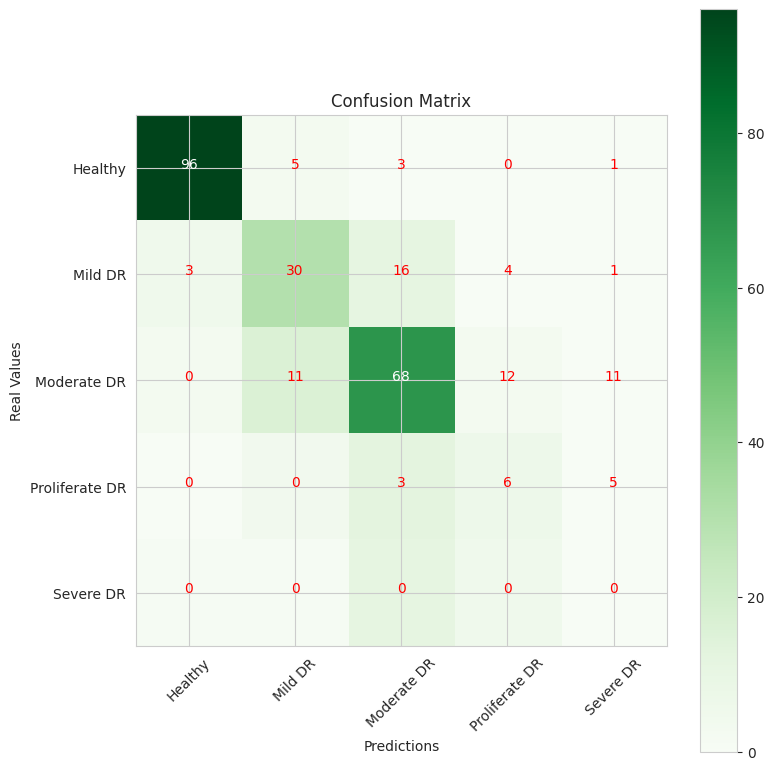

In [34]:
#visualise it
plt.figure(figsize =(8, 8))
plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Greens)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes,rotation = 45)
plt.yticks(tick_marks, classes)

thresh = cm.max()/2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(i, j, cm[i, j], horizontalalignment = 'center', color = 'white' if cm[i,j] > thresh  else 'red')
    
plt.tight_layout()
plt.xlabel('Predictions')
plt.ylabel('Real Values')
plt.savefig("CF.svg", format="svg")
plt.show()

In [35]:
y1 = Test.classes
y2 = y_pred
print(y2)
print("Accuracy: ",accuracy_score(y1, y2))
print("Recall: ",recall_score(y1, y2, average = 'micro'))
print("Precision: ",precision_score(y1, y2, average='micro'))
print("F1_Score: ",f1_score(y1, y2, average = 'micro'))
print("Kappa Score: ",cohen_kappa_score(y1, y2, weights = 'quadratic'))

[0 0 1 1 1 0 2 1 0 1 2 0 0 2 1 1 1 1 1 0 0 0 0 2 1 1 1 2 1 2 2 0 0 2 0 2 0
 2 2 1 0 3 2 1 2 1 0 1 0 2 2 1 2 2 2 0 0 0 2 2 0 2 1 2 0 2 0 0 0 2 0 3 0 0
 2 2 2 1 0 0 2 1 2 2 0 1 0 3 1 1 2 2 2 1 0 1 2 2 2 2 1 1 3 2 0 0 0 3 0 2 2
 1 2 3 0 2 0 3 2 2 0 2 0 1 1 1 2 0 0 2 0 2 0 1 2 2 2 0 2 1 0 0 0 0 0 0 0 0
 0 3 0 0 0 0 1 0 0 2 2 2 2 0 2 0 1 2 0 0 1 0 2 0 2 2 1 3 0 0 0 2 1 1 2 3 0
 2 0 2 2 1 2 0 2 0 0 2 1 3 1 1 2 2 0 2 0 3 1 2 2 0 2 0 2 2 0 0 1 0 2 0 2 2
 2 2 2 2 2 2 2 0 2 0 0 0 0 2 0 0 0 2 0 0 2 2 0 3 0 0 2 0 0 1 2 2 0 0 0 0 1
 2 2 1 2 2 1 2 1 3 0 0 1 2 1 0 2]
Accuracy:  0.7272727272727273
Recall:  0.7272727272727273
Precision:  0.7272727272727273
F1_Score:  0.7272727272727273
Kappa Score:  0.7783669141039237


# 6 Save model

In [36]:
model.save('effB4 CNN DR.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
